## Imports

In [18]:
# Add parent directory to path for local imports
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.datasets as dset
import torchvision.models as models
import torchvision.transforms as T
import bcolz
import time
from torch.utils.data import Dataset, DataLoader, sampler

from utils.features import *
%matplotlib inline

In [19]:
use_gpu = torch.cuda.is_available()
print('Using gpu: %s ' % use_gpu)

def gpu(x,use_gpu=use_gpu):
    if use_gpu:
        return x.cuda()
    else:
        return x

Using gpu: True 


## Data processing

In [4]:
transform = T.Compose([
    T.CenterCrop(224),
    T.ToTensor(),
#     T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = dset.ImageFolder('../Dataset/train', transform=transform)
val_dataset = dset.ImageFolder('../Dataset/val', transform=transform)
test_dataset = dset.ImageFolder('../Dataset/test', transform=transform)

In [5]:
train_size = len(train_dataset)
val_size = len(val_dataset)
test_size = len(test_dataset)
print("Number of training examples {}, validation examples {}, testing examples {}".format(train_size, val_size, test_size))

Number of training examples 66071, validation examples 11016, testing examples 33154


## Method 1: Manual Features Extraction (Preferred)

In [ ]:
def build_features(dataset, mode):
    assert(mode == "train" or mode == "val" or mode == "test")
    i = 0
    for x, y in dataset:
        x = x[None, :, :, :]
        x = x.permute(0, 2, 3, 1)
        x_feats = extract_features(x, feature_fns, verbose=True)
        new_image_features_path = '../ManualFeaturesDataset/{}/{}/{}.npy'.format(mode, y, i)
        os.makedirs(os.path.dirname(new_image_features_path), exist_ok=True)
        np.save(new_image_features_path, x_feats)
        i += 1
        
build_features(train_dataset, "train")
build_features(val_dataset, "val")
build_features(test_dataset, "test")

In [90]:
def npy_loader(path):
    sample = torch.from_numpy(np.load(path))
    return sample

train_dataset = dset.DatasetFolder(
    root='../ManualFeaturesDataset/train',
    loader=npy_loader,
    extensions='.npy'
)
val_dataset = dset.DatasetFolder(
    root='../ManualFeaturesDataset/val',
    loader=npy_loader,
    extensions='.npy'
)
test_dataset = dset.DatasetFolder(
    root='../ManualFeaturesDataset/test',
    loader=npy_loader,
    extensions='.npy'
)

In [91]:
train_size = len(train_dataset)
val_size = len(val_dataset)
test_size = len(test_dataset)
print("Number of training examples {}, validation examples {}, testing examples {}".format(train_size, val_size, test_size))

Number of training examples 66071, validation examples 11016, testing examples 33154


In [92]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=6)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=6)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=6)

In [109]:
def flatten(x):
    N = x.shape[0] # read in N, C, H, W
    return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

# for x,y in train_dataloader:
#     print(x.shape)
#     print(flatten(x).shape)
#     print(y.shape)

## Creating Linear SVM model

In [21]:
def flatten(x):
    N = x.shape[0] # read in N, C, H, W
    return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

class Flatten(nn.Module):
    def forward(self, x):
        return flatten(x)

In [22]:
input_dim = 7066
hidden_layer_size = 1000
output_dim = 172

two_layer_nn = nn.Sequential(
    Flatten(),
    nn.Linear(input_dim, hidden_layer_size),
    nn.ReLU(),
    nn.Linear(hidden_layer_size, output_dim),
)

linear_svm = nn.Sequential(
    Flatten(),
    nn.Linear(input_dim, output_dim)
)

In [114]:
print(linear_svm)

Sequential(
  (0): Flatten()
  (1): Linear(in_features=7066, out_features=172, bias=True)
)


In [115]:
model = gpu(linear_svm)

In [116]:
optimizer = optim.Adam(linear_svm.parameters()) #lr=0.1)

### Training the model

In [119]:
def train_model(model, optimizer, epochs=1):
    train_loss_history = []
    train_accuracy_history = []
    val_loss_history = []
    val_accuracy_history = []
    for epoch in range(epochs):
        model.train()
        num_correct, num_samples, total_loss = 0, 0, 0
        i = 0
        for x, y in train_dataloader:
            x, y = gpu(x.float()), gpu(y)
            scores = model(x)
            # SVM loss function
            criterion = nn.MultiMarginLoss()
            loss = criterion(scores, y)
            # Cross Entropy (Softmax) loss function
            # loss = F.cross_entropy(scores, y)           
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            _,preds = torch.max(scores.data,1)
            total_loss += loss.data.item()
            num_correct += torch.sum(preds == y.data)
            num_samples += preds.size(0)
        average_loss = total_loss / num_samples
        acc = num_correct / num_samples
        train_loss_history.append(average_loss)
        train_accuracy_history.append(acc)
        print('Epoch: {} Training Loss: {:.4f} Got {} / {} correct. Acc: {:.2f}%'.format(
                     epoch + 1, average_loss, num_correct, num_samples, 100 * acc))
        
        check_accuracy(model, val_loss_history, val_accuracy_history, epoch)
    return train_loss_history, train_accuracy_history, val_loss_history, val_accuracy_history

def check_accuracy(model, val_loss_history, val_accuracy_history, epoch):
    num_correct, num_samples, total_loss = 0, 0, 0
    model.eval()
    with torch.no_grad():
        for x, y in val_dataloader:
            x, y = gpu(x.float()), gpu(y)                
            scores = model(x)
            # SVM loss function
            criterion = nn.MultiMarginLoss()
            loss = criterion(scores, y)
            # Cross Entropy (Softmax) loss function
            # loss = F.cross_entropy(scores, y) 
            _, preds = torch.max(scores.data, 1)
            total_loss += loss.data.item()
            num_correct += torch.sum(preds == y.data)
            num_samples += preds.size(0)
        average_loss = total_loss / num_samples
        acc = num_correct / num_samples
    val_loss_history.append(average_loss)
    val_accuracy_history.append(acc)
    print('Epoch: {} Validation Loss: {:.4f} Got {} / {} correct {:.2f}%'.format(
        epoch + 1, average_loss, num_correct, num_samples, 100 * acc))
        

In [120]:
%%time
LOSS, ACC, LOSS_V, ACC_V = train_model(model, optimizer, epochs=50)

Epoch: 1 Training Loss: 0.0112 Got 2331 / 66071 correct. Acc: 3.53%
Epoch: 1 Validation Loss: 0.0103 Got 616 / 11016 correct 5.59%
Epoch: 2 Training Loss: 0.0088 Got 5150 / 66071 correct. Acc: 7.79%
Epoch: 2 Validation Loss: 0.0089 Got 715 / 11016 correct 6.49%
Epoch: 3 Training Loss: 0.0072 Got 7445 / 66071 correct. Acc: 11.27%
Epoch: 3 Validation Loss: 0.0081 Got 890 / 11016 correct 8.08%
Epoch: 4 Training Loss: 0.0062 Got 9040 / 66071 correct. Acc: 13.68%
Epoch: 4 Validation Loss: 0.0076 Got 946 / 11016 correct 8.59%
Epoch: 5 Training Loss: 0.0054 Got 10739 / 66071 correct. Acc: 16.25%
Epoch: 5 Validation Loss: 0.0072 Got 1005 / 11016 correct 9.12%
Epoch: 6 Training Loss: 0.0048 Got 12224 / 66071 correct. Acc: 18.50%
Epoch: 6 Validation Loss: 0.0070 Got 1020 / 11016 correct 9.26%
Epoch: 7 Training Loss: 0.0043 Got 13716 / 66071 correct. Acc: 20.76%
Epoch: 7 Validation Loss: 0.0068 Got 1125 / 11016 correct 10.21%
Epoch: 8 Training Loss: 0.0039 Got 15077 / 66071 correct. Acc: 22.82%
E

In [121]:
PATH = "../saved_models/food/linear_svm/baseline.dat"
torch.save(model, PATH)
torch.save({'loss': LOSS, 'acc': ACC, 'loss_v': LOSS_V, 'acc_v': ACC_V}, '../saved_models/food/linear_svm/baseline-history.pt')

## Evaluation

In [23]:
def flatten(x):
    N = x.shape[0] # read in N, C, H, W
    return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

class Flatten(nn.Module):
    def forward(self, x):
        return flatten(x)

In [24]:
# Load the model.
PATH = "../saved_models/food/linear_svm/baseline.dat"
loaded_model = torch.load(PATH)
loaded_model = gpu(loaded_model)
model = loaded_model
history = torch.load('../saved_models/food/linear_svm/baseline-history.pt')
LOSS, ACC, LOSS_V, ACC_V = history['loss'], history['acc'], history['loss_v'], history['acc_v']

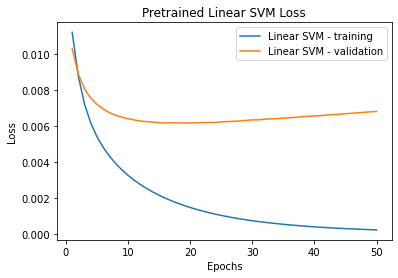

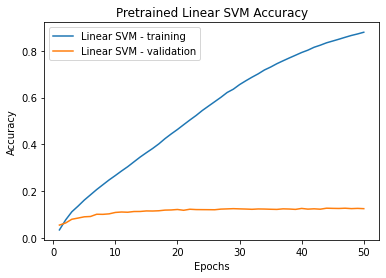

In [25]:
# Loss and Accuracy Curves
from utils.plots import plot_loss_and_accuracy_curves
plot_loss_and_accuracy_curves('Linear SVM', LOSS, ACC, LOSS_V, ACC_V)

In [11]:
# Evaluation: Top-1 Accuracy

def compute_top_1_accuracy(model):
    correct = 0
    total = 0
    with torch.no_grad():
        model.eval()
        for x, y in test_dataloader:
            x, y = gpu(x.float()), gpu(y)
            outputs = model(x)
            _, predicted = torch.max(outputs.data, 1)
            total += y.size(0)
            correct += (predicted == y).sum().item()

    print('Top 1 Accuracy of the network on the all test images: %.2f %%' % (
        100 * correct / total))

compute_top_1_accuracy(model)

Top 1 Accuracy of the network on the all test images: 12.61 %


In [12]:
# Evaluation: Top-5 Accuracy

def compute_top_5_accuracy(model):
    correct = 0
    total = 0
    with torch.no_grad():
        model.eval()
        for x, y in test_dataloader:
            x, y = gpu(x.float()), gpu(y)
            outputs = model(x)
            _, predicted = torch.topk(outputs.data, 5, dim=1)
            total += y.size(0)
            for i in range(predicted.shape[0]):
                top_5_predictions = predicted[i]
                label = y[i]
                if label in top_5_predictions:
                    correct += 1
    print('Top 5 Accuracy of the network on the all test images: %.2f %%' % (
        100 * correct / total))
    
compute_top_5_accuracy(model)

Top 5 Accuracy of the network on the all test images: 28.40 %


In [71]:
import sklearn.metrics
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

In [73]:
# Store y_pred and y_test on the test set for evaluation.

y_pred = []
y_test = []
with torch.no_grad():
    model.eval()
    for x, y in test_dataloader:
        x, y = gpu(x.float()), gpu(y)
        outputs = model(x)
        _, predicted = torch.max(outputs.data, 1)
        y_pred.extend(predicted.cpu().numpy().tolist())
        y_test.extend(y.cpu().numpy().tolist())

In [74]:
cnf_matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix\n')
print(cnf_matrix)

Confusion Matrix

[[76 12  2 ...  1  5  2]
 [33 39  0 ...  0  3  5]
 [10  3  8 ...  0  1  1]
 ...
 [ 1  8  0 ... 20  0  5]
 [31  1  0 ...  0 37  1]
 [ 5  6  0 ...  3  0 30]]


<AxesSubplot:>

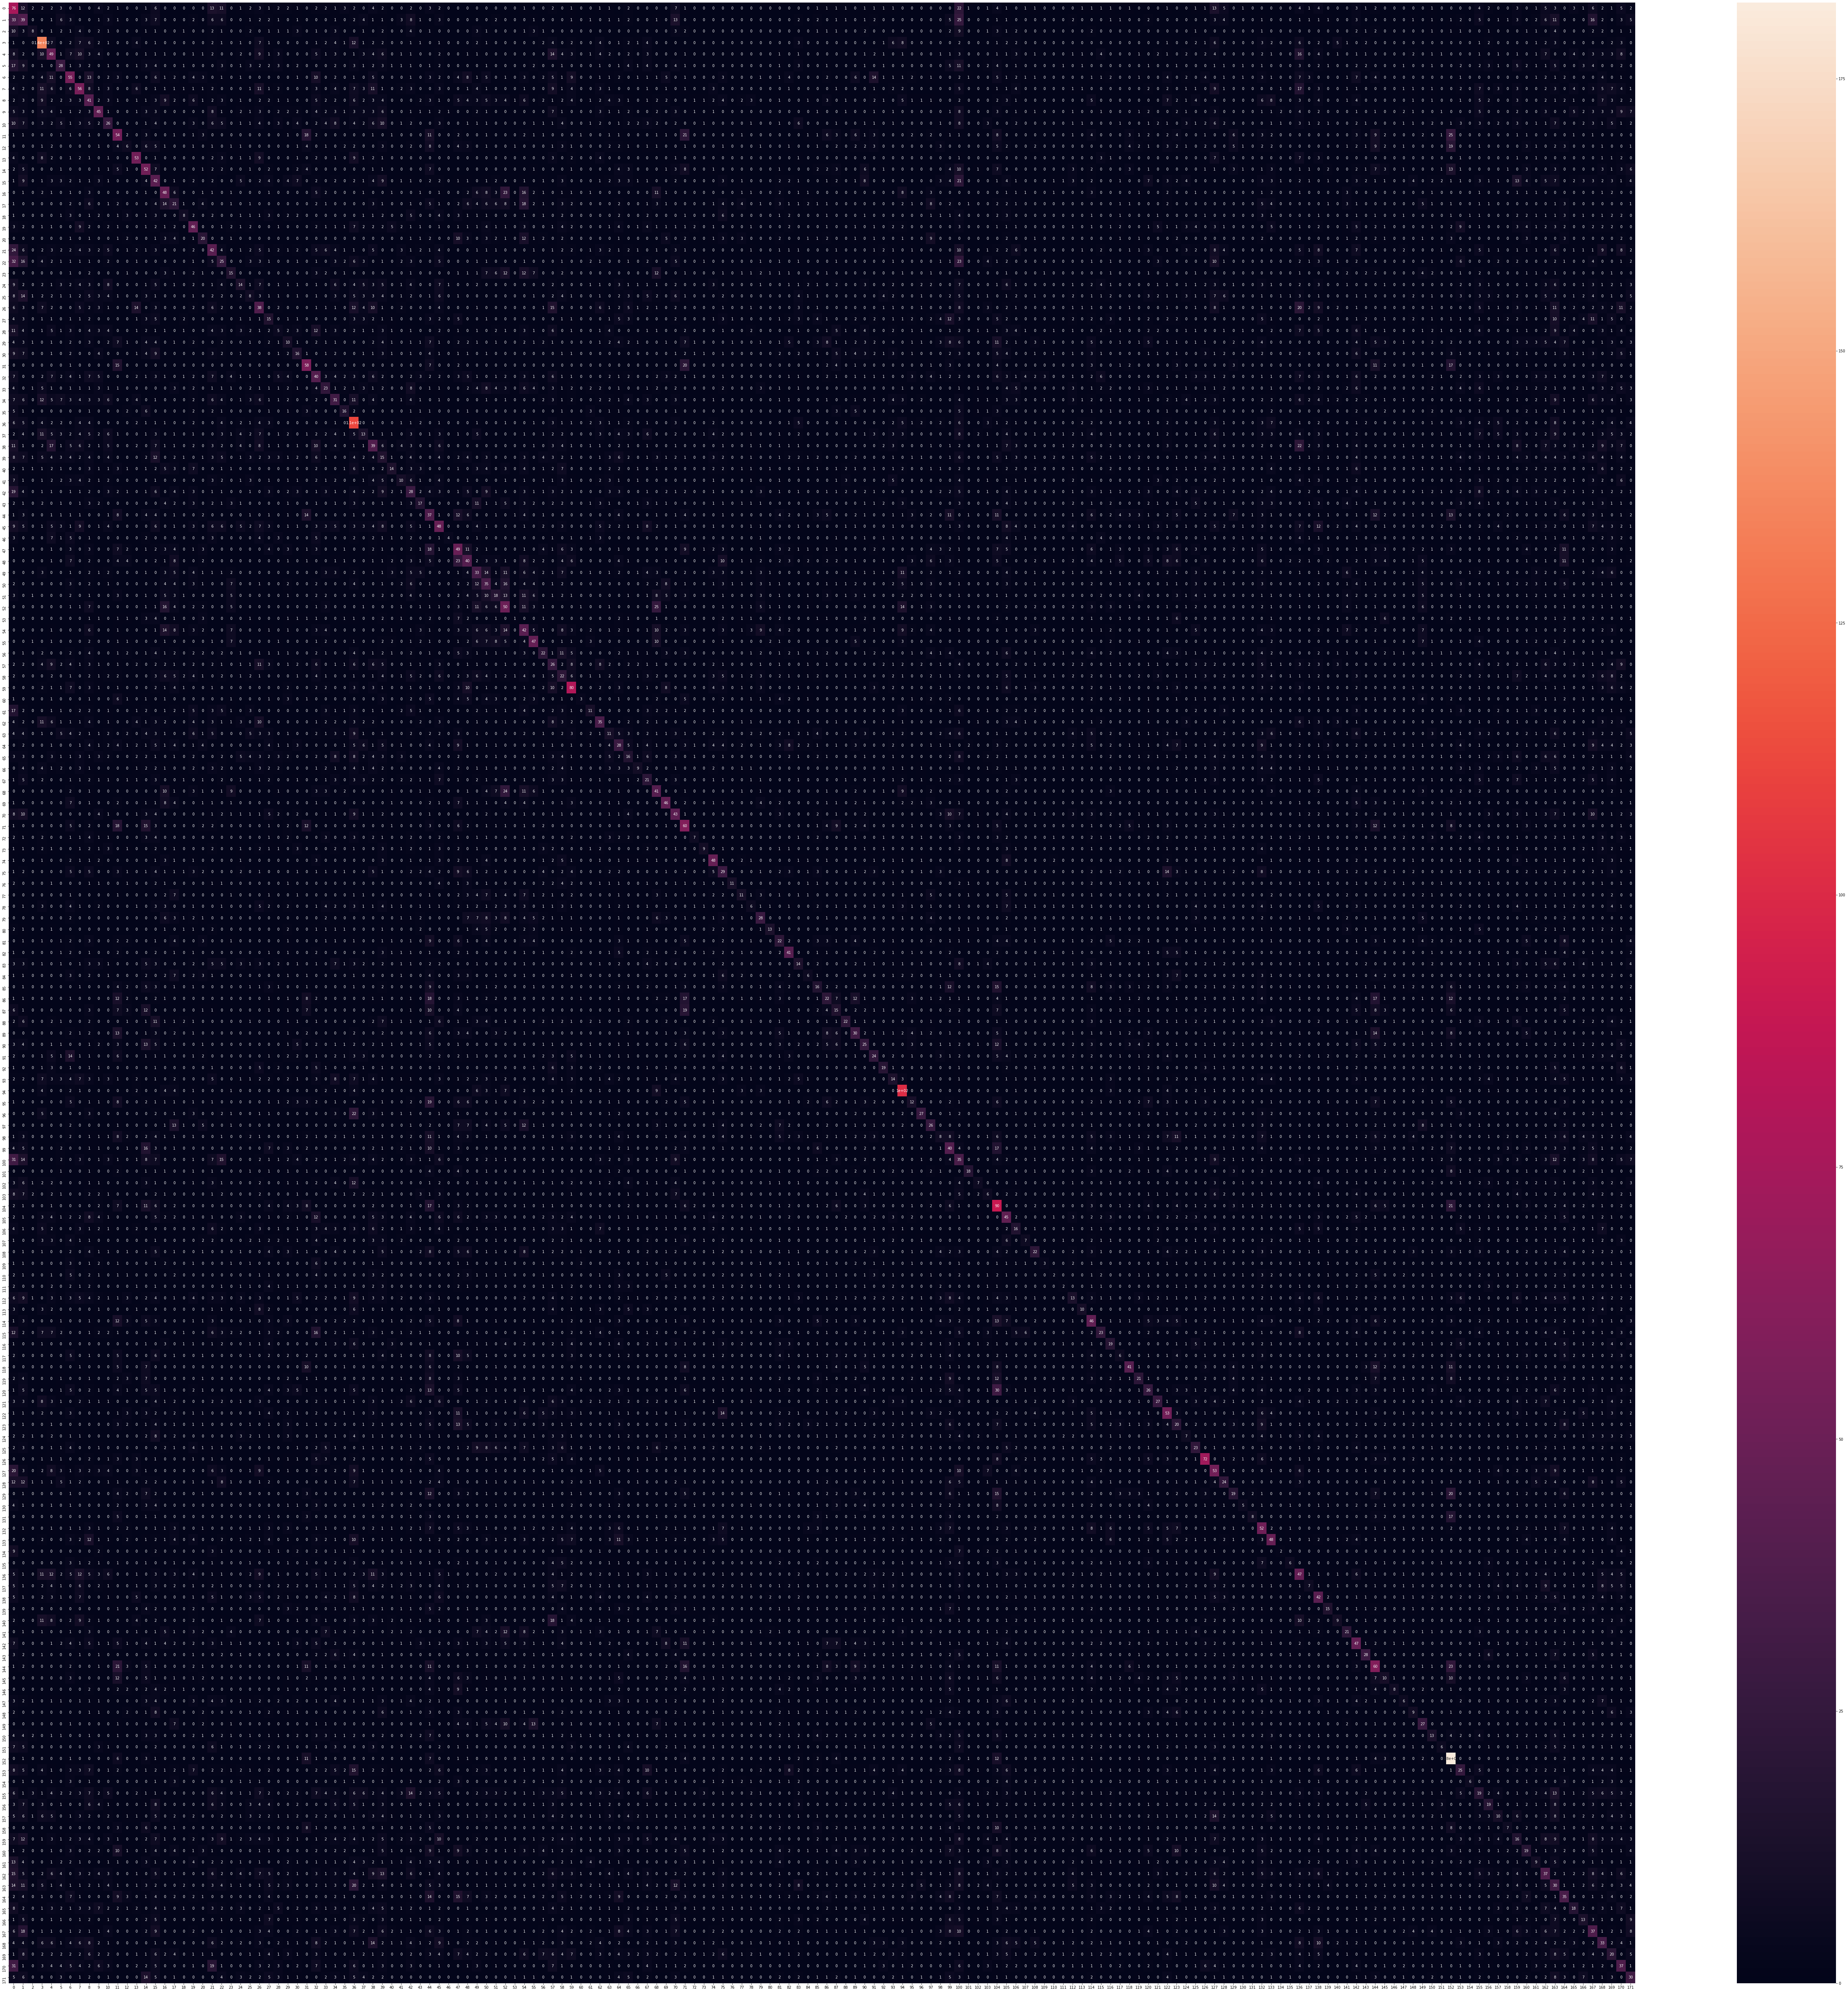

In [75]:
# Visualizing the confusion matrix 

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
array = cnf_matrix.tolist()
df_cm = pd.DataFrame(array, index = [i for i in range(172)],
                  columns = [i for i in range(172)])
plt.figure(figsize = (100,100))
sn.heatmap(df_cm, annot=True)

In [76]:
# Evaluation: Compute several statistics such as accuracy, precision, F1-score, and produce a classification report

FOOD_LIST_PATH = '../VireoFood172/SplitAndIngreLabel/FoodList.txt'
food_names = [] # List of length 172 where index is the food label, and value is the food name.
with open(FOOD_LIST_PATH) as fp:
    food_names = fp.read().splitlines()
    
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test, y_pred)))

print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))

from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(y_test, y_pred, target_names=food_names))


Accuracy: 0.15

Micro Precision: 0.15
Micro Recall: 0.15
Micro F1-score: 0.15

Macro Precision: 0.17
Macro Recall: 0.14
Macro F1-score: 0.14

Weighted Precision: 0.15
Weighted Recall: 0.15
Weighted F1-score: 0.14

Classification Report

                                              precision    recall  f1-score   support

                                Braised Pork       0.10      0.25      0.14       307
                          Sautéed Spicy Pork       0.08      0.14      0.10       287
             Cripsy sweet & sour pork slices       0.27      0.07      0.11       120
               Steamed pork with rice powder       0.32      0.45      0.38       299
                  Pork with salted vegetable       0.15      0.18      0.16       277
                   Shredded Pork with pepper       0.16      0.14      0.15       205
                     Yu-Shiang Shredded Pork       0.16      0.19      0.17       292
  Sautéed Sliced Pork, Eggs and Black Fungus       0.19      0.19      0.

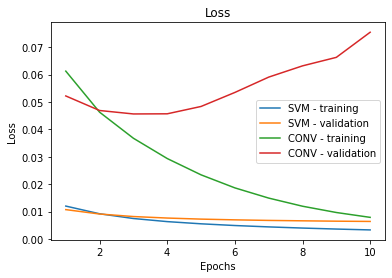

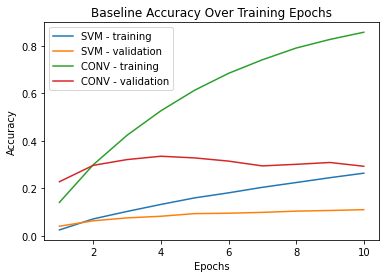

Final SVM Training Accuracy:  tensor(0.2633, device='cuda:0')
Final SVM Validation Accuracy:  tensor(0.1097, device='cuda:0')
Final CONV Training Accuracy:  tensor(0.8569, device='cuda:0')
Final SVM Validation Accuracy:  tensor(0.2925, device='cuda:0')


In [71]:
# Plot both baselines on a SINGLE plot

history_linearsvm = torch.load('../saved_models/linear_svm/baseline-history.pt')
LOSS_SVM, ACC_SVM, LOSS_V_SVM, ACC_V_SVM = (history_linearsvm['loss'], history_linearsvm['acc'], 
                                            history_linearsvm['loss_v'], history_linearsvm['acc_v'])
LOSS_SVM, ACC_SVM, LOSS_V_SVM, ACC_V_SVM = LOSS_SVM[:10], ACC_SVM[:10], LOSS_V_SVM[:10], ACC_V_SVM[:10]
history_convbaseline = torch.load('../saved_models/baseline-history.pt')
LOSS_CONV, ACC_CONV, LOSS_V_CONV, ACC_V_CONV = (history_convbaseline['loss'], history_convbaseline['acc'], 
                                                history_convbaseline['loss_v'], history_convbaseline['acc_v'])

plt.figure()
E = np.arange(10)+1
plt.plot(E,LOSS_SVM,label='SVM - training')
plt.plot(E,LOSS_V_SVM,label='SVM - validation')
plt.plot(E,LOSS_CONV,label='CONV - training')
plt.plot(E,LOSS_V_CONV,label='CONV - validation')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss")
plt.legend()
plt.show()
plt.figure()
plt.plot(E,ACC_SVM,label='SVM - training')
plt.plot(E,ACC_V_SVM,label='SVM - validation')
plt.plot(E,ACC_CONV,label='CONV - training')
plt.plot(E,ACC_V_CONV,label='CONV - validation')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Baseline Accuracy Over Training Epochs")
plt.legend()
plt.show()
print("Final SVM Training Accuracy: ", ACC_SVM[-1])
print("Final SVM Validation Accuracy: ", ACC_V_SVM[-1])
print("Final CONV Training Accuracy: ", ACC_CONV[-1])
print("Final SVM Validation Accuracy: ", ACC_V_CONV[-1])

## Method 2: Manual Features Extraction ( This is too Memory Intensive...)

In [ ]:
# Define feature functions (HOG + Color Histogram)

num_color_bins = 10 # 10 Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]

In [7]:
def build_features(dataloader):
    x_feats = []
    i = 0
    for x, y in dataloader:
        if i % 10 == 0:
            print("Computed {} batches".format(i))CS23
        x = x.permute(0, 2, 3, 1)
        x_feats.append(extract_features(x, feature_fns, verbose=True))
        i += 1
    return np.concatenate(x_feats)

In [ ]:
X_train_feats = build_features(train_dataloader)
print(X_train_feats.shape)

In [ ]:
X_val_feats = build_features(val_dataloader)
print(X_val_feats.shape)

In [ ]:
X_test_feats = build_features(test_dataloader)
print(X_test_feats.shape)

In [9]:
np.save('../manual_features/color_hog_train.npy', X_train_feats)
np.save('../manual_features/color_hog_val.npy', X_val_feats)
np.save('../manual_features/color_hog_test.npy', X_test_feats)    

In [13]:
with open('../manual_features/color_hog_train.npy', 'rb') as f:
    X_train_feats = np.load(f)
print(X_train_feats.shape)

with open('../manual_features/color_hog_val.npy', 'rb') as f:
    X_val_feats = np.load(f)
print(X_val_feats.shape)

with open('../manual_features/color_hog_test.npy', 'rb') as f:
    X_test_feats = np.load(f)
print(X_test_feats.shape)

(33154, 9226)


In [19]:
# Preprocessing

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat
# np.save('../manual_features/color_hog_train.npy', X_train_feats)
# np.save('../manual_features/color_hog_val.npy', X_val_feats)
# np.save('../manual_features/color_hog_test.npy', X_test_feats)    

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat
# np.save('../manual_features/color_hog_train.npy', X_train_feats)
# np.save('../manual_features/color_hog_val.npy', X_val_feats)
# np.save('../manual_features/color_hog_test.npy', X_test_feats)    

In [15]:
# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

In [29]:
import torch
from torch.utils.data import Dataset, DataLoader

import numpy as np

class ManualFeaturesDataset(Dataset):
    def __init__(self, data, target, transform=None):
        self.data = torch.from_numpy(data).float()
        self.target = torch.from_numpy(target).long()
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        
        if self.transform:
            x = self.transform(x)
        
        return x, y
    
    def __len__(self):
        return len(self.data)